In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

import sys 
sys.path.append("../../")


## Base A/B Testing Problem

In [2]:
mu = -0.002
tau = 0.01
sigma = 5.
mu_p = max(mu,0)

def mvar(n):
  return tau**2 + sigma**2/n

def production_function(n):
  return tau**2/(np.sqrt(2*np.pi*mvar(n))) * np.exp(-mu**2 * mvar(n)/(2* tau**4)) + mu*norm.cdf(mu*np.sqrt(mvar(n))/tau**2) - mu_p

2.41149202673957


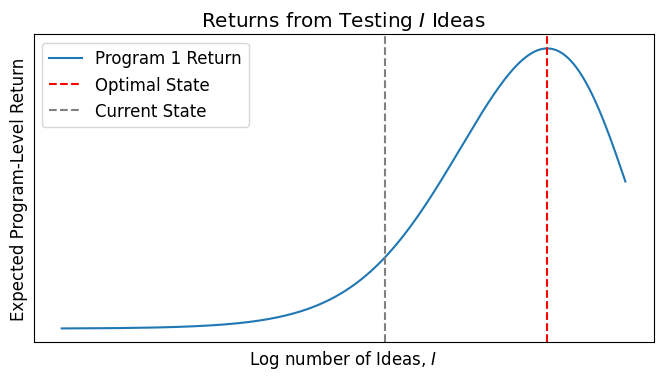

In [3]:
plt.rcParams['font.size'] = 12
I = 50_000
N = 250e6
x = np.arange(1,I)
plt.figure(figsize = (8,4))
plt.plot(np.log(x),x*production_function(N/x), label = "Program 1 Return")
plt.title("Returns from Testing $I$ Ideas")
plt.xlabel("Log number of Ideas, $I$")
plt.ylabel("Expected Program-Level Return")
plt.yticks([])
plt.xticks([])

print(I*production_function(N/I))
opt = np.argmax(x*production_function(N/x))
plt.axvline(np.log(opt), color = 'red', linestyle = 'dashed', label = 'Optimal State')
plt.axvline(np.log(500), color = 'gray', linestyle = 'dashed', label = 'Current State')
plt.legend()

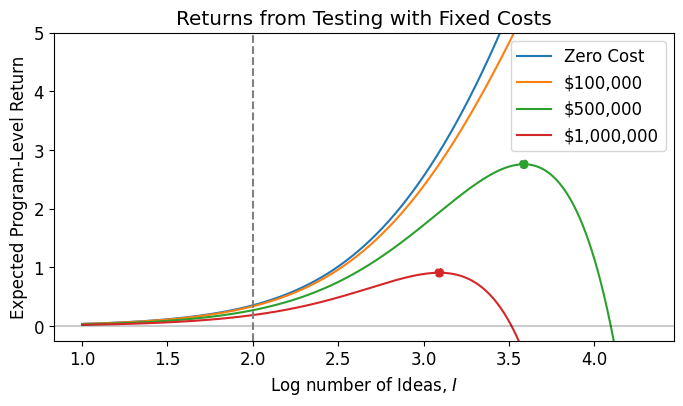

In [4]:
plt.rcParams['font.size'] = 12
I = 20_000
N = 250e6


mu = -0.00055
c0 = 100000/6e8 # converts from dollars to QPD. In terms of mu?
#c = 0.5*np.abs(mu)

x = np.arange(10,I)
plt.figure(figsize = (8,4))
#plt.plot(x,x*production_function(N/x), label = names[program])

labels = ["Zero Cost", "$100,000","$500,000","$1,000,000"]
costs = [0,c0,5*c0,10*c0]

for i,c in enumerate(costs):
    a = x*production_function(N/x) - c*x
    line, = plt.plot(np.log10(x),a, label = labels[i])
    opt_cost = x[np.argmax(a)]
    plt.scatter(np.log10(opt_cost), opt_cost*(production_function(N/opt_cost) - c), color = line.get_color(), linestyle = 'dashed')
plt.title("Returns from Testing with Fixed Costs")
plt.xlabel("Log number of Ideas, $I$")
plt.ylabel("Expected Program-Level Return")

plt.ylim([-0.25,5])

plt.axhline(0, color = 'black', alpha = 0.2)
plt.axvline(np.log10(100), color = 'gray', linestyle = 'dashed')
plt.legend()

In [5]:
def optimal_production(N,I):
    #approximate value
    x = np.arange(1,I+1)
    return max(x*production_function(N/x))

As expected, the solution is lean experimentation. All ideas should be tested. When the production function is concave, this is always the case, regardless of $N$.

### Check Dynamic Programming Solution

How important is the mesh size? Will the solution change much if we discretize in a different way?

In [6]:
N = 10e6
N_step = 1e4 # this should be smaller than $N/I$

I = 1000
I_step = 25 

N_range = np.arange(1,N, N_step)
I_range = np.arange(1,I, I_step)


In [11]:
from methods.dp import *

dp_res = optimal_production_DP(N,I,N_step, I_step, production_function)

/var/folders/gc/wdmtwr2d6zd6mgxqyn23rjmc0000gn/T/ipykernel_13983/3729331284.py:7: RuntimeWarning: divide by zero encountered in divide
  return tau**2 + sigma**2/n


In [12]:
dp_res.shape

(40, 25000)

In [41]:
#np.save(f"metaproduction_array_N_step{N_step}_I_step{I_step}",dp_res)

## Metaproduction Function

### Increasing number of people & Number of Ideas

In [13]:
# First subplot
opt_vals = dp_res
#opt_vals = np.load(f"metaproduction_array_N_step{N_step}_I_step{I_step}.npy")

n_idx = np.searchsorted(N_range, 249e6)
i_idx = np.searchsorted(I_range, 50)

# Second subplot
opt_vals_I = opt_vals[:,n_idx]

# Third subplot
opt_vals_N = opt_vals[i_idx,:]

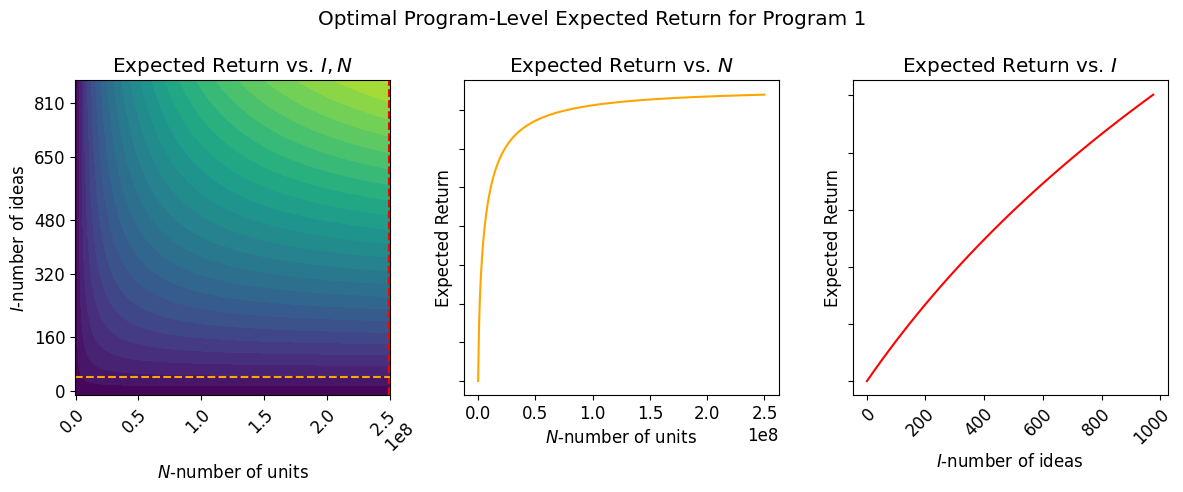

In [14]:
from scipy.ndimage import zoom

fig, (ax3, ax1, ax2) = plt.subplots(1, 3, figsize=(12,5))

# Plot the first subplot
ax1.plot(N_range, opt_vals_N, color = 'orange')
ax1.set_title("Expected Return vs. $N$")
ax1.set_xlabel("$N$-number of units")
ax1.set_ylabel("Expected Return")
ax1.tick_params(axis='y', labelleft=False)  # Remove y labels

# Plot the second subplot
ax2.plot(I_range, opt_vals_I, color = 'red')
ax2.set_title("Expected Return vs. $I$")
ax2.set_xlabel("$I$-number of ideas")
ax2.set_ylabel("Expected Return")
ax2.tick_params(axis='y', labelleft=False)  # Remove y labels

plt.setp(ax2.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Downscale the opt_vals matrix
downscale_factor = 0.01  # Adjust this factor to control downscaling
opt_vals_downscaled = zoom(opt_vals, (1, downscale_factor))

# Create new I_range and N_range for the downscaled matrix
I_range_downscaled = np.linspace(0, I_range[-1], opt_vals_downscaled.shape[0])
N_range_downscaled = np.linspace(0, N_range[-1], opt_vals_downscaled.shape[1])

# Plot the downscaled heatmap
heatmap = ax3.contourf(opt_vals_downscaled, cmap='viridis', levels=30)

# Overlay the lines (adjusted for downscaled indices)
N_index = np.searchsorted(N_range_downscaled, 249e6)
I_index = np.searchsorted(I_range_downscaled, 50)

ax3.axvline(x=N_index, color='red', linestyle='--', linewidth=1.5)
ax3.axhline(y=I_index, color='orange', linestyle='--', linewidth=1.5)

# Set the ticks at the center of each cell
ax3.set_xticks(np.arange(opt_vals_downscaled.shape[1]) + 0.5, minor=False)
ax3.set_yticks(np.arange(opt_vals_downscaled.shape[0]) + 0.5, minor=False)

# Select a subset of the range for labeling to avoid crowding
num_x_labels = 6
num_y_labels = 7
x_indices = np.linspace(0, len(N_range_downscaled) - 1, num=num_x_labels, dtype=int)
ax3.set_xticks(x_indices + 0.5, minor=False)

# Set x-tick labels with scientific notation for the rightmost tick
x_labels = [f'{N_range_downscaled[i]/1e8:.1f} \n 1e8' if i == x_indices[-1] else f'{N_range_downscaled[i]/1e8:.1f}' for i in x_indices]
ax3.set_xticklabels(x_labels, rotation=90)

y_indices = np.linspace(0, len(I_range_downscaled) - 1, num=num_y_labels, dtype=int)
y_labels = np.linspace(I_range_downscaled[0], I_range_downscaled[-1], num=num_y_labels)
ax3.set_yticks(y_indices + 0.5, minor=False)
ax3.set_yticklabels([f'{10*int(y/10)}' for y in y_labels])

ax3.set_title("Expected Return vs. $I,N$")
ax3.set_xlabel("$N$-number of units")
ax3.set_ylabel("$I$-number of ideas")

ax3.set_ylim(0,35)

# Angle the x-axis tick labels
plt.setp(ax3.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Remove colorbar
# plt.colorbar(heatmap)

# title
plt.suptitle(f"Optimal Program-Level Expected Return for Program 1")

# Ensure tight layout for better spacing
plt.tight_layout()

# Optionally, display the plot
plt.show()